# Toxicity in Video Game Communities
Toxicity is a prelevant part of gaming whether it be in or out of games. Players insult others due to a variety of reasons. Due to the lack of personal interaction over the internet, toxic players are unable to see the direct effect of their toxic behaviors. This notebook aims to answer some questions regarding the toxicity in these communities.

As a fan of MMORPGs, I've played both Final Fantasy 14 by Square Enix, and World of Warcraft by Blizzard Entertainment. In general, it seems as though the MMORPG communities believe WoW to be a more toxic environment, and that FF14 is more catered to friendly or 'casual' play. I wanted to see if this truly was the case.

## Jigsaw Toxic Comments Challenge
This notebook uses data taken from the jigsaw toxic comments challenge on Kaggle to act as a dataset for toxic comments. Although toxicity in the Jigsaw challenge was multiclass, I simplified the problem to be purely a binary classification problem. This was so that the reduction in the problem complexity could provide a more accurate answer to the question, 'is WoW more toxic than FF14?'

### LSTM Model
To accomplish this task, I used Tensorflow and Keras to implement an RNN using a word embedding layer and a bidirectional LSTM. As this is written originally with Google Colab, I used Google Colab's TPUs to train the network. The network was only trained for 5 epochs, but showed decent results as a baseline on the Jigsaw problem. I added bits of regularization and tuned some hyperparameters, as the model overfits often.

The jigsaw problem resulted in an accuracy of only 87% on the test case.

### Data from Reddit Comments
This model was then used to predict comments on the gaming subreddits. I used /r/wow and /r/ffxiv. Data from these comments were taken using the Pushshift API in a randomly chosen week. The data was saved into CSVs and then converted into Pandas dataframes from which we process and send to the model.

The result from this initial test is that FF14 contains ~6% toxic comments whereas WoW contains ~8%. This does seem to indicate a higher level of toxicity in WoW than in FF14. However, this is only with a single sample taken over a week. As this is only a preliminary test, there are many things we can do to improve the performance of the network.

## Future Work
Getting data from the subreddits and then labeling them into a dev-set would give a representation of how our model is doing on the actual data (subreddit comments). The current validation set and test set comes from the Jigsaw comment challenge, and is not of the same data distribution of subreddit comments. By having labeled data and then using a transfer learning approach, we can develop a model that performs better on the subreddit comments.

Also, tuning the model to perform better on the Jigsaw training-dev set could also provide a better starting point for our model.

In [32]:
from google.colab import drive
import os
import tensorflow as tf
import numpy as np

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, GRU
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import pandas as pd
from tqdm import tqdm
print(tf.__version__)

2.3.0


In [2]:
# TPU Connection
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.118.86.50:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.118.86.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.86.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
# Mount google drive and select correct files

# drive.mount('/content/drive/')
data_dir = '/content/drive/My Drive/ColabData/ToxicComments/'
# !ls /content/drive/My\ Drive/ColabData/ToxicComments
os.listdir(data_dir)

['train.csv',
 'test.csv',
 'test_labels.csv',
 'leagueoflegends2020-07-30to2020-08-06.csv',
 'wow2020-07-30to2020-08-06.csv',
 'ffxiv2020-07-30to2020-08-06.csv',
 'token_json.txt',
 'jigsawmodel.h5',
 'wow500.csv',
 'ff500.csv',
 'lol500.csv',
 'wow500.gsheet',
 'lol500.gsheet',
 'ff500.gsheet']

In [5]:
traindf = pd.read_csv(data_dir+'train.csv')
testdf = pd.read_csv(data_dir+'test.csv')
test_labelsdf = pd.read_csv(data_dir+'test_labels.csv')

In [ ]:
# print(traindf.isnull().any(), testdf.isnull().any())
# traindf.head()
# testdf.head()
# test_labelsdf.head()
# test_labelsdf['toxic'].value_counts()
# traindf['toxic'].value_counts()


In [6]:
toxcols = list(traindf.columns[2:])
print(toxcols)
istoxic = [0 for i in range(len(traindf))]
ids = []
for i in tqdm(range(len(traindf))):
  for col in toxcols:
    if traindf[col][i] == 1:
      istoxic[i] = 1
traindf['istoxic'] = istoxic

  1%|▏         | 2254/159571 [00:00<00:06, 22534.81it/s]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


100%|██████████| 159571/159571 [00:06<00:00, 24722.44it/s]


In [7]:
toxcol_test = list(test_labelsdf.columns[1:])
print(toxcol_test)
istoxic_test = [-1 for i in range(len(test_labelsdf))]
for i in tqdm(range(len(test_labelsdf))):
  for col in toxcol_test:
    if test_labelsdf[col][i] == 0 and istoxic_test[i] != 1:
      istoxic_test[i] = 0
    if test_labelsdf[col][i] == 1:
      istoxic_test[i] = 1
testdf['istoxic'] = istoxic_test
testdf.head()

  1%|          | 1204/153164 [00:00<00:12, 12033.61it/s]

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


100%|██████████| 153164/153164 [00:12<00:00, 12485.06it/s]


,id,comment_text,istoxic
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1


In [8]:
testdf['istoxic'].value_counts()

-1    89186
 0    57735
 1     6243
Name: istoxic, dtype: int64

In [9]:
testdf_clean = testdf.loc[testdf['istoxic'] != -1]
testdf_clean.head()

,id,comment_text,istoxic
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0
7,000247e83dcc1211,:Dear god this site is horrible.,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(traindf.iloc[:,1], traindf['istoxic'], test_size = 0.2, random_state = 0)

In [11]:
MAX_FEATURES = 20000
MAXLEN = 100

tokenizer = text.Tokenizer(num_words = MAX_FEATURES)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_train = sequence.pad_sequences(X_train, maxlen = MAXLEN)
X_valid = sequence.pad_sequences(X_valid, maxlen = MAXLEN)

In [13]:
# callbacks
callback = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

# Construct Model
with tpu_strategy.scope():
  model = Sequential()
  model.add(Embedding(MAX_FEATURES, 100))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         234496    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [14]:
BATCH_SIZE = 32
EPOCHS = 5

history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data=(X_valid, Y_valid))

Epoch 1/5
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   1/3990 [..............................] - ETA: 2:14:45 - loss: 0.6932 - accuracy: 0.6250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.0251s). Check your callbacks.


3990/3990 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9521WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_test_batch_end` time: 0.0119s). Check your callbacks.


3990/3990 [==============================] - 125s 31ms/step - loss: 0.1398 - accuracy: 0.9521 - val_loss: 0.1095 - val_accuracy: 0.9607
Epoch 2/5
3990/3990 [==============================] - 119s 30ms/step - loss: 0.0951 - accuracy: 0.9654 - val_loss: 0.1045 - val_accuracy: 0.9634
Epoch 3/5
3990/3990 [==============================] - 119s 30ms/step - loss: 0.0780 - accuracy: 0.9705 - val_loss: 0.1233 - val_accuracy: 0.9629
Epoch 4/5
3990/3990 [==============================] - 121s 30ms/step - loss: 0.0625 - accuracy: 0.9764 - val_loss: 0.1382 - val_accuracy: 0.9606
Epoch 5/5
3990/3990 [==============================] - 120s 30ms/step - loss: 0.0466 - accuracy: 0.9829 - val_loss: 0.1421 - val_accuracy: 0.9576


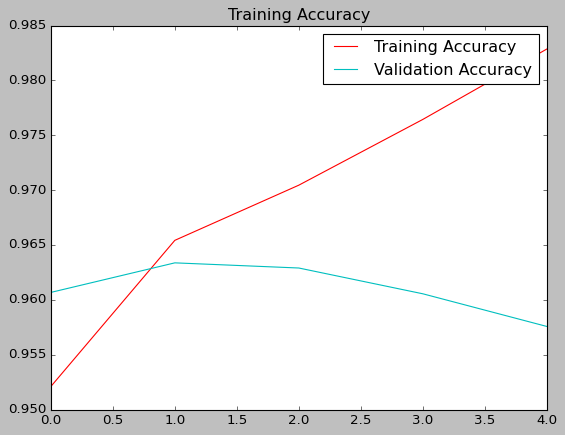

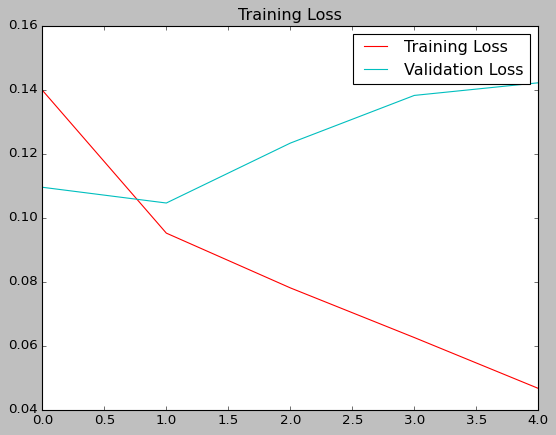

In [73]:
import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
plt.style.use(['classic'])

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'c', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'c', label='Validation Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [25]:
# Predictions

X_test = testdf_clean.iloc[:,1]
Y_test = testdf_clean['istoxic']
X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, maxlen = MAXLEN)


In [30]:
# Predict and
Y_pred = model.predict_classes(X_test, verbose=1)
Y_pred_prob = model.predict(X_test, verbose=1)
conf = confusion_matrix(y_true=Y_test, y_pred=Y_pred)

   1/2000 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_predict_batch_end` time: 0.0107s). Check your callbacks.


   1/2000 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_predict_batch_end` time: 0.0087s). Check your callbacks.


2000/2000 [==============================] - 18s 9ms/step


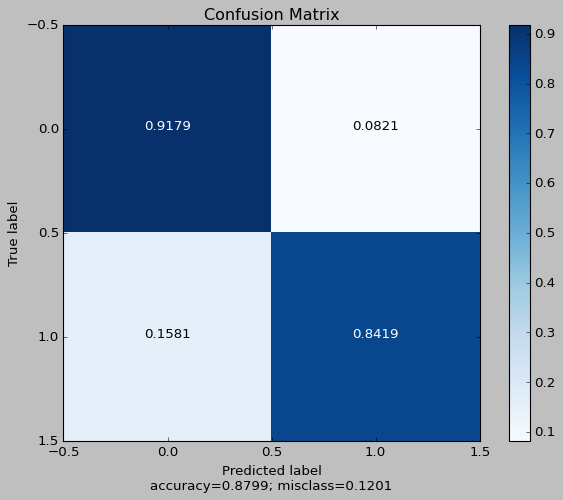

In [75]:
# Build confusion matrix

import itertools

conf_acc = np.trace(conf) / float(np.sum(conf))
conf_misclass = 1-conf_acc

plt.figure(figsize=(8, 6))
plt.imshow(conf, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
thresh = conf.max()/1.5

for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, "{:0.4f}".format(conf[i, j]),
              horizontalalignment="center",
              color="white" if conf[i, j] > thresh else "black")
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(conf_acc, conf_misclass))
plt.show()

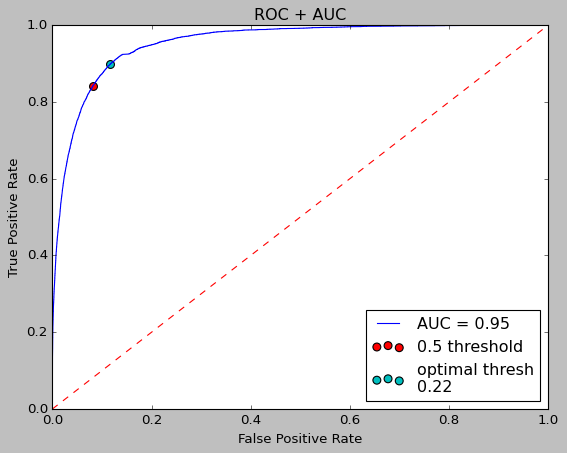

In [78]:
# ROC/AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmin(np.sqrt(np.square(1-tpr)+np.square(fpr)))
# print(optimal_idx)
# print(threshold[optimal_idx])


plt.figure()
plt.title('ROC + AUC')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' %roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.scatter(fpr[4029], tpr[4029], s=50, c='r', label='0.5 threshold')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], s=50, c='c', label='optimal thresh\n%0.2f'%threshold[optimal_idx])
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

plt.show()

In [ ]:
# Save model
import json

model.save(data_dir+'jigsawmodel_2.h5')
token_json = tokenizer.to_json()
with open(data_dir+'token_json.txt', 'w') as outfile:
  json.dump(token_json, outfile)

In [ ]:
df_ffxiv = pd.read_csv(data_dir+'ffxiv2020-07-30to2020-08-06.csv')
df_wow = pd.read_csv(data_dir+'wow2020-07-30to2020-08-06.csv')
df_lol = pd.read_csv(data_dir+'leagueoflegends2020-07-30to2020-08-06.csv')

In [ ]:
df_wow['text'].fillna(' ', inplace=True) # Wow and lol dataset contain nan's, replace
df_lol['text'].fillna(' ', inplace=True)

In [ ]:
X_test_ff = df_ffxiv.iloc[:,1]
X_test_wow = df_wow.iloc[:,1]
X_test_lol = df_lol.iloc[:,1]

In [ ]:
X_test_ff = tokenizer.texts_to_sequences(X_test_ff)
X_test_ff = sequence.pad_sequences(X_test_ff, maxlen=MAXLEN)

X_test_wow = tokenizer.texts_to_sequences(X_test_wow)
X_test_wow = sequence.pad_sequences(X_test_wow, maxlen=MAXLEN)

X_test_lol = tokenizer.texts_to_sequences(X_test_lol)
X_test_lol = sequence.pad_sequences(X_test_lol, maxlen=MAXLEN)

In [ ]:
Y_pred_ff = model.predict_classes(X_test_ff, verbose = 1)
Y_pred_wow = model.predict_classes(X_test_wow, verbose = 1)
Y_pred_lol = model.predict_classes(X_test_lol, verbose = 1)

  1/827 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_predict_batch_end` time: 0.0132s). Check your callbacks.


   1/1367 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0076s). Check your callbacks.


   1/4038 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_predict_batch_end` time: 0.0088s). Check your callbacks.


4038/4038 [==============================] - 42s 10ms/step


In [ ]:
df_ffxiv["istoxic_pred"] = Y_pred_ff
df_wow["istoxic_pred"] = Y_pred_wow
df_lol["istoxic_pred"] = Y_pred_lol

In [ ]:
# df_ffxiv["istoxic_pred"].value_counts()
# df_wow["istoxic_pred"].value_counts()
# df_lol["istoxic_pred"].value_counts()

ffxiv_toxiclevels = df_ffxiv['istoxic_pred'].value_counts()[1]/len(df_ffxiv)
wow_toxiclevels = df_wow['istoxic_pred'].value_counts()[1]/len(df_wow)
lol_toxiclevels = df_lol['istoxic_pred'].value_counts()[1]/len(df_lol)

In [ ]:
print("Percentage of Comments that are Toxic in Subreddits")
print("="*50)
print("FFXIV: ".ljust(10) + str(ffxiv_toxiclevels).ljust(25) + ("%.4f%%" % (ffxiv_toxiclevels*100)))
print("WoW: ".ljust(10) + str(wow_toxiclevels).ljust(25) + ("%.4f%%" % (wow_toxiclevels*100)))
print("LoL: ".ljust(10) + str(lol_toxiclevels).ljust(25) + ("%.4f%%" % (lol_toxiclevels*100)))

Percentage of Comments that are Toxic in Subreddits
FFXIV:    0.06179095446982302      6.1791%
WoW:      0.0810062893081761       8.1006%
LoL:      0.0982105540161917       9.8211%
